# **实验作业-4：多重共线性**
刘蔚璁 10225501443

## **任务**
### **数据预处理**
1. 从 scikit-learn 包中载入数据集 diabetes。
2. 通过阅读以下参考文献1和2，定义清楚问题背景、数据中响应变量和自变量的概念、取值范围等信息。
3. 以学号的最后三位数字作为随机种子，采用留出法划分训练集和测试集，样本比例为$7.5:2.5$。
### **模型构建**
在本次实验中我们将 a quantitative measure of disease progression one year after baseline 作为响应变量，根据参考文献2来构建的特征，并训练模型。

4. 判断用于建模的特征数据中是否存在多重共线性？提供合适的判断方案。
5. 构建线性回归模型 Model_1、岭回归模型 Model_2、主成分回归模型 Model_3。
### **模型评价**
6. 利用 RMSE，比较 Model_1、Model_2、Model_3 在测试集上的预测效果。请进行评论。

## **解决方案**

### **实验前的准备**

首先载入实验所需要的 Python 包：

In [ ]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import load_diabetes

import os

import pandas as pd
import numpy as np
import random
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

from sklearn import preprocessing # Data Preprocessing
import statsmodels.api as sm # LSE, Ridge Regression
from statsmodels.stats.outliers_influence import variance_inflation_factor # VIF 
from statsmodels.multivariate.pca import PCA # PCR

### **Step1.载入数据集**

scikit-learn 包中自带了一些小数据集，我们所要使用的是其中用于回归的糖尿病数据集，可以使用 `load_diabetes(*[, return_X_y, as_frame, scaled])` 加载原始数据集：

In [336]:
diabetes_data = load_diabetes()
X= pd.DataFrame(diabetes_data.data, columns=diabetes_data.feature_names)
y = pd.Series(diabetes_data.target)

# 查看数据的基本信息
print(X.head())
print(y.head())

        age       sex       bmi        bp        s1        s2        s3   
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401  \
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641  
0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
dtype: float64


先简单统计一下这个数据集中的一些基本信息，如样本量、特征维度：

In [35]:
p = X.shape[1]
n = X.shape[0]

print("The number of features is",p)
print("The sample size is",n)

The number of features is 10
The sample size is 442


接着根据参考文献 2 构造二次项和交叉项，这里使用 scikit-learn 中的 `PolynomialFeatures`，可以自动生成交叉项，**注意构造结果不包括性别的二次项**：

In [92]:
# 创建多项式特征（包括二次项和交互项）
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# 创建特征名称
feature_names = poly.get_feature_names_out(X.columns)
feature_names = [name.replace(' ', '_') for name in feature_names]

# 将生成的特征转换为 DataFrame
X_poly = pd.DataFrame(X_poly, columns=feature_names)

# 排除 sex*sex 这一项
X_poly= X_poly.loc[:, X_poly.columns != 'sex^2']

# 提取所有带 ^2 的列名
squared_features = [col for col in X_poly.columns if '^2' in col]
# 提取不带 ^2 的列名
non_squared_features = [col for col in X_poly.columns if '^2' not in col]
# 将带 ^2 的列插入到第11个特征位置
ordered_features = non_squared_features[:10] + squared_features + non_squared_features[10:]
# 重新排列 DataFrame 的列
X_poly = X_poly[ordered_features]

# 查看结果
print(X_poly.head())
print("The number of features is", X_poly.shape[1])

        age       sex       bmi        bp        s1        s2        s3   
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401  \
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  ...     s2_s3     s2_s4     s2_s5     s2_s6   
0 -0.002592  0.019907 -0.017646  ...  0.001511  0.000090 -0.000693  0.000614  \
1 -0.039493 -0.068332 -0.092204  ... -0.001426  0.000757  0.001309  0.001767   
2 -0.002592  0.002861 -0.025930  ...  0.001106  0.000089 -0.000098  0.000887   
3  0.034309  0.022688 -0.009362  ... -0.000901  0.000857  0.000567 -0.000234   
4 -0.002592 -0.031988 -0.046641  ...  0.000127 -0.000040 -0.000499 -0.000727   

      s3_s4     s3_s5     s3_s6     s4_s5     s4_s6     s5_s6  
0  0

更新特征数量：

In [252]:
p = X_poly.shape[1]
print("the number of features is",p)

the number of features is 64


### **Step2.定义**

#### **问题背景**

本次数据来自于糖尿病患者的临床研究，收集了442名患者的基线信息和一年的疾病进展指标。数据记录了患者的基本特征以及相关的血清测量值，旨在通过这些信息分析影响疾病进展的因素。

#### **数据**

在本次数据中，共有11个变量（1个响应变量与10个自变量），具体如下表所示：

<table width = c(100,800,700), center = True> 
<tr> <td> 变量名 </td> <td> 英文变量含义 </td> <td> 中文变量含义 </td> </tr> 
<tr> <td> age </td> <td> Age in years </td> <td> 年龄（以年为单位） </td> </tr> 
<tr> <td> sex </td> <td> Gender (1: male, 0: female) </td> <td> 性别（1：男性，0：女性） </td> </tr> 
<tr> <td> bmi </td> <td> Body mass index </td> <td> 体重指数 </td> </tr> 
<tr> <td> bp </td> <td> Average blood pressure </td> <td> 平均血压 </td> </tr> 
<tr> <td> s1 </td> <td> Total serum cholesterol (tc) </td> <td> 总胆固醇 </td> </tr> 
<tr> <td> s2 </td> <td> Low-density lipoproteins (ldl) </td> <td> 低密度脂蛋白 </td> </tr> 
<tr> <td> s3 </td> <td> High-density lipoproteins (hdl) </td> <td> 高密度脂蛋白 </td> </tr> 
<tr> <td> s4 </td> <td> Total cholesterol / HDL (tch) </td> <td> 胆固醇与高密度脂蛋白的比值 </td> </tr> 
<tr> <td> s5 </td> <td> Possibly log of serum triglycerides level (ltg) </td> <td> 可能是血清甘油三酯的对数 </td> </tr> 
<tr> <td> s6 </td> <td> Blood sugar level (glu) </td> <td> 血糖水平 </td> </tr> 
<tr> <td> y </td> <td> Quantitative measure of disease progression after one year </td> <td> 一年后疾病进展的定量指标 </td> </tr>
 </table>
 
我们希望研究糖尿病患者的临床特征与疾病进展之间的关系。因此，y 是本次模型中的响应变量，其余10个变量为自变量。数据中的各变量已进行均值中心化和标准化，确保分析的有效性和准确性。

接着统计各数据的取值范围：

In [338]:
# 计算特征的取值范围
feature_min = X.min()  # 每个特征的最小值
feature_max = X.max()  # 每个特征的最大值

# 计算标签的取值范围
label_min = y.min()  # 标签的最小值
label_max = y.max()  # 标签的最大值

# 打印特征的取值范围
print("Feature Min Values:\n", feature_min)
print("Feature Max Values:\n", feature_max)

# 打印标签的取值范围
print("Label Min Value:", label_min)
print("Label Max Value:", label_max)

Feature Min Values:
 age   -0.107226
sex   -0.044642
bmi   -0.090275
bp    -0.112399
s1    -0.126781
s2    -0.115613
s3    -0.102307
s4    -0.076395
s5    -0.126097
s6    -0.137767
dtype: float64
Feature Max Values:
 age    0.110727
sex    0.050680
bmi    0.170555
bp     0.132044
s1     0.153914
s2     0.198788
s3     0.181179
s4     0.185234
s5     0.133597
s6     0.135612
dtype: float64
Label Min Value: 25.0
Label Max Value: 346.0


### **Step3.使用留出法划分训练集和测试集**

In [236]:
n_train = math.ceil(n * 0.75)
print("训练集数量：",n_train)
n_test = n-n_train
print("测试集数量：",n_test)
seed = 443
random.seed(seed)
index = range(0,n)
index_selected = random.sample(index,n_train)
index_selected.sort()

X_train = X_poly.loc[index_selected]
y_train = y.loc[index_selected]
X_test = X_poly.drop(index = index_selected)
y_test = y.drop(index = index_selected)

训练集数量： 332
测试集数量： 110


用于建模的数据集：

In [237]:
X_train.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,...,s2_s3,s2_s4,s2_s5,s2_s6,s3_s4,s3_s5,s3_s6,s4_s5,s4_s6,s5_s6
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,...,-0.001426,0.000757,0.001309,0.001767,-0.002939,-0.005085,-0.006861,0.002699,0.003641,0.006300
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,...,0.001106,0.000089,-0.000098,0.000887,0.000084,-0.000093,0.000839,-0.000007,0.000067,-0.000074
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,...,-0.000901,0.000857,0.000567,-0.000234,-0.001236,-0.000818,0.000337,0.000778,-0.000321,-0.000212
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,...,0.000127,-0.000040,-0.000499,-0.000727,-0.000021,-0.000260,-0.000380,0.000083,0.000121,0.001492
5,-0.092695,-0.044642,-0.040696,-0.019442,-0.068991,-0.079288,0.041277,-0.076395,-0.041176,-0.096346,...,-0.003273,0.006057,0.003265,0.007639,-0.003153,-0.001700,-0.003977,0.003146,0.007360,0.003967


In [238]:
y_train.head()

1     75.0
2    141.0
3    206.0
4    135.0
5     97.0
dtype: float64

用于评价的数据集：

In [239]:
X_test.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,...,s2_s3,s2_s4,s2_s5,s2_s6,s3_s4,s3_s5,s3_s6,s4_s5,s4_s6,s5_s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,...,0.001511,0.000090,-0.000693,0.000614,0.000113,-0.000864,0.000766,-0.000052,0.000046,-0.000351
9,-0.070900,-0.044642,0.039062,-0.033213,-0.012577,-0.034508,-0.024993,-0.002592,0.067737,-0.013504,...,0.000862,0.000089,-0.002337,0.000466,0.000065,-0.001693,0.000338,-0.000176,0.000035,-0.000915
12,0.016281,-0.044642,-0.028840,-0.009113,-0.004321,-0.009769,0.044958,-0.039493,-0.030748,-0.042499,...,-0.000439,0.000386,0.000300,0.000415,-0.001776,-0.001382,-0.001911,0.001214,0.001678,0.001307
28,0.052606,-0.044642,-0.021295,-0.074527,-0.040096,-0.037639,-0.006584,-0.039493,-0.000612,-0.054925,...,0.000248,0.001486,0.000023,0.002067,0.000260,0.000004,0.000362,0.000024,0.002169,0.000034
29,0.067136,0.050680,-0.006206,0.063187,-0.042848,-0.095885,0.052322,-0.076395,0.059424,0.052770,...,-0.005017,0.007325,-0.005698,-0.005060,-0.003997,0.003109,0.002761,-0.004540,-0.004031,0.003136


In [240]:
y_test.head()

0     151.0
9     310.0
12    179.0
28    131.0
29    283.0
dtype: float64

### **Step4.判断用于建模的特征数据中是否存在多重共线性**

#### **对数据进行标准化/中心化**

首先对训练集和测试集的特征和标签分别进行标准化和中心化，使得标准化后的数据均值为 0 且 $\mathbf{x}_i'\mathbf{x}_i=1$：

In [296]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train_scaled = (X_train - mean) / (std * np.sqrt(X_train.shape[0]-1))

mean = y_train.mean(axis=0)
y_train_center = (y_train - mean)

X_train_scaled.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,...,s2_s3,s2_s4,s2_s5,s2_s6,s3_s4,s3_s5,s3_s6,s4_s5,s4_s6,s5_s6
1,-0.001368,-0.050740,-0.058893,-0.029699,-0.007472,-0.020035,0.082440,-0.043419,-0.076595,-0.102630,...,-0.023487,-0.012830,0.014894,0.027210,-0.023156,-0.102527,-0.154394,0.027027,0.059986,0.115602
2,0.101456,0.059362,0.052928,-0.005679,-0.050743,-0.037686,-0.036587,-0.001727,0.004857,-0.027006,...,0.039516,-0.024763,-0.021647,0.005569,0.037906,0.021285,0.035513,-0.031775,-0.019209,-0.025317
3,-0.104191,-0.050740,-0.012405,-0.041709,0.016567,0.031817,-0.040692,0.039965,0.027540,-0.008100,...,-0.010417,-0.011034,-0.004385,-0.021981,0.011234,0.003303,0.023142,-0.014700,-0.027815,-0.028372
4,0.007201,-0.050740,-0.041303,0.026347,0.006951,0.020784,0.008561,-0.001727,-0.035014,-0.050639,...,0.015149,-0.027068,-0.032060,-0.034113,0.035785,0.017122,0.005455,-0.029812,-0.018019,0.009304
5,-0.108476,-0.050740,-0.046328,-0.021692,-0.077988,-0.090640,0.045501,-0.085110,-0.045527,-0.107356,...,-0.069434,0.081829,0.065664,0.171575,-0.027490,-0.018572,-0.083261,0.036740,0.142386,0.064022


In [297]:
mean = X_test.mean(axis=0)
std = X_test.std(axis=0)
X_test_scaled = (X_test - mean) / (std * np.sqrt(X_test.shape[0]-1))

mean = y_test.mean(axis=0)
y_test_center = (y_test - mean)

X_test_scaled.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,...,s2_s3,s2_s4,s2_s5,s2_s6,s3_s4,s3_s5,s3_s6,s4_s5,s4_s6,s5_s6
0,0.067786,0.097096,0.114719,0.038273,-0.099270,-0.079380,-0.095094,-0.012513,0.032556,-0.051583,...,0.081228,-0.048131,-0.056794,-0.001529,0.074147,-0.006068,0.078969,-0.055942,-0.039548,-0.060070
9,-0.138005,-0.093628,0.070574,-0.069850,-0.036887,-0.078776,-0.053419,-0.012513,0.131540,-0.042853,...,0.052627,-0.048158,-0.125135,-0.008030,0.071648,-0.051699,0.055483,-0.061371,-0.040006,-0.085272
12,0.026628,-0.093628,-0.061860,-0.022546,-0.020613,-0.031075,0.104944,-0.092077,-0.072276,-0.103959,...,-0.004749,-0.038359,-0.015497,-0.010255,-0.024723,-0.034604,-0.067783,-0.000504,0.030058,0.014093
28,0.095225,-0.093628,-0.047145,-0.150943,-0.091133,-0.084814,-0.011745,-0.092077,-0.009909,-0.130147,...,0.025535,-0.001962,-0.027025,0.062086,0.081872,0.041715,0.056807,-0.052624,0.050981,-0.042854
29,0.122664,0.097096,-0.017715,0.119366,-0.096557,-0.197125,0.121614,-0.171641,0.114335,0.096816,...,-0.206535,0.191102,-0.264805,-0.249981,-0.141056,0.212645,0.188361,-0.252482,-0.213366,0.095905


#### **绘制热力图**

首先，我们可以通过绘图来直观感受特征之间的相关性。

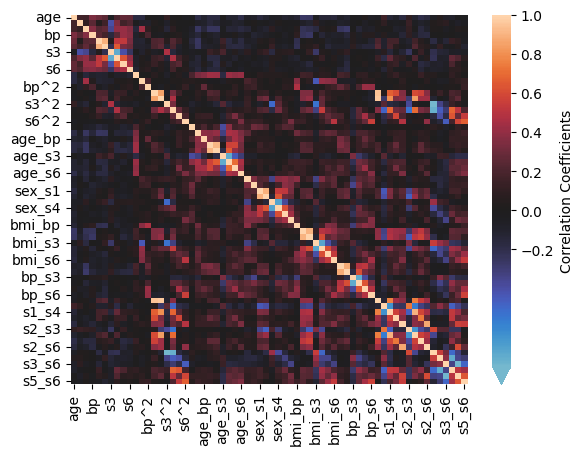

In [263]:
pcorr = X_train_scaled.corr(method = 'pearson')
tick_ = (np.arange(0,13,2)-2)/10
dict_ = {"orientation":'vertical',
         'label':'Correlation Coefficients',
         "drawedges":False,
         "ticklocation":"top",
         "extend":"min",
         "alpha":0.8,
         "cmap":"cmap",
         "ticks":tick_}
sns.heatmap(pcorr,cbar_kws= dict_,center=0)

plt.savefig("./Fig_heatmap.pdf",dpi=400)

颜色越浅的特征之间的相关性越强，而颜色越深的特征之间的相关性越弱。由于特征数量过多，我们无法分辨出具体关系，但由图中浅色方块的分布区域可以推测，部分相邻变量可能出现多重共线性。

#### **方差扩大因子法**

##### **定义**
假定特征数据已经经过标准化，现数据有
$$
X = \begin{pmatrix}
x_{11} & x_{12} & \cdots & x_{1p}\\
x_{21} & x_{22} & \cdots & x_{2p}\\
\vdots & \vdots &  & \vdots \\
x_{n1} & x_{n2} & \cdots & x_{np}\\
\end{pmatrix}
$$
于是样本相关矩阵定义为
$$\mathbf{R}=\mathbf{X}'\mathbf{X}$$
这个样本相关矩阵的逆矩阵记为
$$(\mathbf{X}'\mathbf{X})^{-1}$$
我们称方阵 $(\mathbf{X}'\mathbf{X})^{-1}$ 主对角线元素 $\text{VIF}_j$ 为第 $j$ 个自变量的方差扩大因子。

##### **基本思想**
$\text{VIF}_j$ 越大，自变量 $x_j$ 与其他自变量之间的多重共线性程度越严重。

##### **判断标准**
- 当 $\text{VIF}_j<c_{\text{VIF}}$ 时， 自变量 $x_j$ 与其余自变量之间不存在多重共线性；
- 当 $\text{VIF}_j>c_{\text{VIF}}$ 时， 自变量 $x_j$ 与其余自变量之间存在多重共线性。

在本次实验中，我们将临界值 $c_{\text{VIF}}$ 设定为 5：

In [283]:
vif_cv = 5

- ##### **法一：矩阵计算**

In [272]:
C = np.linalg.inv(np.dot(X_train_scaled.T,X_train_scaled))
VIF_1 = np.diag(C)
print("The VIF's are", np.round(VIF_1,2))

The VIF's are [1.57000000e+00 1.57000000e+00 2.79000000e+00 1.84000000e+00
 1.07212564e+07 8.14427007e+06 1.63478296e+06 2.89100000e+01
 1.20109725e+06 1.78000000e+00 1.72000000e+00 2.64000000e+00
 2.20000000e+00 8.65510500e+04 5.79035200e+04 3.02165000e+03
 1.51420000e+02 8.33567000e+03 3.03000000e+00 2.09000000e+00
 2.23000000e+00 2.12000000e+00 1.30920000e+02 8.33800000e+01
 3.05000000e+01 1.64900000e+01 2.13100000e+01 2.25000000e+00
 2.19000000e+00 2.08000000e+00 1.27220000e+02 7.84200000e+01
 3.01600000e+01 1.58600000e+01 1.95800000e+01 2.01000000e+00
 2.72000000e+00 1.75730000e+02 1.28050000e+02 3.93300000e+01
 1.78600000e+01 2.46200000e+01 2.95000000e+00 1.54910000e+02
 1.07070000e+02 3.52600000e+01 1.41800000e+01 2.75100000e+01
 3.13000000e+00 2.64231020e+05 2.01022500e+04 9.96270000e+02
 4.90535390e+05 1.32830000e+02 1.63680400e+04 6.94500000e+02
 3.22731830e+05 1.00690000e+02 3.97990000e+02 6.44041900e+04
 3.42300000e+01 1.32180000e+02 2.04300000e+01 3.03600000e+01]


统计 $\text{VIF}$ 中大于临界值的个数：

In [ ]:
count = np.sum(VIF_1 > vif_cv)
print("Number of VIF values greater than 5 is", count)

Number of VIF values greater than 5 is 45


- ##### **法二：使用 statsmodel 包**

In [273]:
VIF_2 = [variance_inflation_factor(X_train_scaled.iloc[:,0:p], i) for i in range(p)]
print("The VIF's are", np.round(VIF_2,2))

The VIF's are [1.57000000e+00 1.57000000e+00 2.79000000e+00 1.84000000e+00
 1.07212563e+07 8.14426996e+06 1.63478294e+06 2.89100000e+01
 1.20109723e+06 1.78000000e+00 1.72000000e+00 2.64000000e+00
 2.20000000e+00 8.65510500e+04 5.79035100e+04 3.02165000e+03
 1.51420000e+02 8.33567000e+03 3.03000000e+00 2.09000000e+00
 2.23000000e+00 2.12000000e+00 1.30920000e+02 8.33800000e+01
 3.05000000e+01 1.64900000e+01 2.13100000e+01 2.25000000e+00
 2.19000000e+00 2.08000000e+00 1.27220000e+02 7.84200000e+01
 3.01600000e+01 1.58600000e+01 1.95800000e+01 2.01000000e+00
 2.72000000e+00 1.75730000e+02 1.28050000e+02 3.93300000e+01
 1.78600000e+01 2.46200000e+01 2.95000000e+00 1.54910000e+02
 1.07070000e+02 3.52600000e+01 1.41800000e+01 2.75100000e+01
 3.13000000e+00 2.64231010e+05 2.01022500e+04 9.96270000e+02
 4.90535380e+05 1.32830000e+02 1.63680400e+04 6.94500000e+02
 3.22731830e+05 1.00690000e+02 3.97990000e+02 6.44041900e+04
 3.42300000e+01 1.32180000e+02 2.04300000e+01 3.03600000e+01]


法一法二计算的结果相同。

- ##### **法三：使用回归系数计算**
    以$x_j$作为响应变量，其他特征$x_1,x_2,\cdots,x_{j-1},x_{j+1},\cdots,x_{p}$作为自变量，构建线性回归模型即
    $$
    x_j = \alpha_0 + \alpha_1 x_1 + \alpha_2 x_2 + \cdots +\alpha_{j-1}x_{j-1} + \alpha_{j+1}x_{j+1} + \cdots + \alpha_p x_p +\epsilon
    $$
    如果这个特征能够被其他特征近似看作其他特征的线性组合，那么我们称这个现象为**多重共线性**。基于这个想法，如果上述回归模型的决定系数$R^2$很接近于1，那么这个特征很有可能看作其他特征的线性组合。因此，多重共线性VIF还有一种计算方法，即
    $$\text{VIF}_j=\frac{1}{1-R_j^2}$$

使用上述公式计算各特征的 $\text{VIF}$ 并输出最大值：

In [276]:
max_VIF = 0
j = 0
for i in range(p):
    X = X_train_scaled.iloc[:, i]
    X_others = X_train_scaled.iloc[:, np.delete(np.arange(p), i)]
    model_vif = sm.OLS(X, sm.add_constant(X_others)).fit()
    vif = 1 / (1 - model_vif.rsquared)

    if vif > max_VIF :
        max_VIF = vif
        j = i

print("The max VIF is",max_VIF,"of",j+1,"th feature")

The max VIF is 10721256.29959233 of 5 th feature


可以看到第五个特征的方差扩大因子超级大，说明存在严重的多重共线性。

#### **特征值法**

##### **概述**
当行列式 $|\mathbf{X}_s'\mathbf{X}_s|\approx0$ 时，矩阵 $\mathbf{X}_s'\mathbf{X}_s$ 至少存在一个特征值近似为零。反之，当矩阵 $\mathbf{X}_s'\mathbf{X}_s$ 至少存在一个特征值为零时， $\mathbf{X}_s$ 的列向量间必然存在多重共线性。

##### **判定方法**
假设 $\mathbf{X}_s'\mathbf{X}_s$ 的特征值分别为 $\lambda_1\ge\cdots\ge\lambda_p$，称
$$
\kappa_j = \sqrt{\frac{\lambda_1}{\lambda_j}},j=1,2,\cdots,p
$$
为特征值 $\lambda_j$ 的条件数。
- 如果设计矩阵 $\mathbf{X}_s$ 没有多重共线性，即最小特征值 $\lambda_p$ 不会接近零，那么条件数 $\kappa_j$ 不会特别大；
- 如果设计矩阵 $\mathbf{X}_s$ 存在多重共线性，即最小特征值 $\lambda_p$ 接近零，那么条件数 $\kappa_j$ 会特别大。

常用的判断标准
- $0<\kappa_j<c_k$ 时，设计矩阵 $\mathbf{X}_s$ 没有多重共线性；
- $\kappa_j\ge c_k$ 时，设计矩阵 $\mathbf{X}_s$ 存在多重共线性。

临界值 $c_k$ 的常见取值有 $10,100,1000$。

此处临界值 $c_k$ 取 10：

In [288]:
c_k = 10

- ##### **法一：根据公式计算**

In [289]:
R = np.dot(X_train_scaled.T,X_train_scaled)
W, V = np.linalg.eig(R)
W = -1* np.sort(-1*W)
W_diag = np.diag(W)
V = V.T
print("The eigen values are", np.round(W,4))

The eigen values are [1.0565e+01 6.0232e+00 5.1814e+00 4.3221e+00 3.1021e+00 2.9543e+00
 2.6052e+00 2.4767e+00 2.1426e+00 1.9491e+00 1.7006e+00 1.6295e+00
 1.4848e+00 1.1843e+00 1.1586e+00 1.0413e+00 9.9250e-01 9.6160e-01
 8.8580e-01 8.2390e-01 7.6160e-01 7.1640e-01 7.0840e-01 6.6350e-01
 6.5070e-01 6.1310e-01 5.7510e-01 5.2150e-01 5.0910e-01 4.9940e-01
 4.4580e-01 4.2330e-01 4.2080e-01 3.7790e-01 3.4910e-01 3.3320e-01
 2.8080e-01 2.7050e-01 2.6010e-01 2.2970e-01 2.2370e-01 2.1250e-01
 1.8280e-01 1.4550e-01 9.6100e-02 7.6300e-02 5.2900e-02 4.8200e-02
 4.0400e-02 3.1700e-02 2.3700e-02 2.1200e-02 1.5400e-02 9.6000e-03
 6.2000e-03 4.6000e-03 3.5000e-03 3.2000e-03 2.8000e-03 2.5000e-03
 1.9000e-03 4.0000e-04 0.0000e+00 0.0000e+00]


注意！`np.linalg.eig` 函数所输出特征值并不是按从大到小的顺序进行排列的。

基于所计算的特征值计算条件数：

In [292]:
Condition_Number = np.sqrt(np.max(W)/np.min(W))
print("The condition number is",np.round(Condition_Number,4))
if Condition_Number > c_k:
    print("存在多重共线性！")

The condition number is 15588.2107
存在多重共线性！


- ##### **法二：拟合模型直接得到条件数**

In [ ]:
model_ols = sm.OLS(y_train_center,X_train_scaled).fit()
print("The condition number is",round(model_ols.condition_number,4))

The condition number is 15588.2106


#### **综上所述，**
用于建模的数据存在严重的多重共线性。

### **Step5.模型构建**

#### **Model_1：线性回归模型**

直接通过 `statsmodels` 库中的用于执行普通最小二乘回归的函数 `OLS`构造模型，并生成回归分析的详细报告：

In [310]:
# 因为对特征进行了标准化、对标签进行了中心化，消除了截距项的影响，因此不用添加截距项
model_1 = sm.OLS(y_train_center,X_train_scaled).fit()
print(model_1.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.627
Model:                            OLS   Adj. R-squared (uncentered):              0.537
Method:                 Least Squares   F-statistic:                              7.026
Date:                Tue, 05 Nov 2024   Prob (F-statistic):                    9.21e-31
Time:                        19:00:52   Log-Likelihood:                         -1748.5
No. Observations:                 332   AIC:                                      3625.
Df Residuals:                     268   BIC:                                      3868.
Df Model:                          64                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [330]:
model_1_coef = model_1.params
model_1_coef

age         67.380944
sex       -248.186192
bmi        422.422703
bp         221.687472
s1       84433.995344
             ...     
s3_s5     9458.138768
s3_s6       -9.249951
s4_s5      508.323644
s4_s6      256.860195
s5_s6     -255.944259
Length: 64, dtype: float64

#### **Model_2：岭回归模型**

当设计矩阵 $X$ 存在多重共线性时 $|\mathbf{X}'\mathbf{X}|\approx0$，导致 $(\mathbf{X}'\mathbf{X})^{-1}$ 计算不稳定，回归系数的最小二乘估计效果明显变差。因此，我们采用
$$
\mathbf{X}'\mathbf{X}+k\mathbf{I},\quad k>0
$$
代替 $\mathbf{X}'\mathbf{X}$，称
$$
\hat{\beta}(k) = (\mathbf{X}'\mathbf{X}+k\mathbf{I})^{-1}\mathbf{X}'\mathbf{y}
$$
为回归系数 $\beta$ 的岭回归估计，其中，称 $k$ 为岭参数。

岭回归估计 $\hat{\beta}(k)$ 是最小化带有 $L_2$ 正则项的离差平方和的解，即
$$
\hat{\beta}(k) = \arg \min_{\beta}(\mathbf{y}-\mathbf{X\beta})'(\mathbf{y}-\mathbf{X\beta})+\lambda\mathbf{\beta}'\mathbf{\beta}
$$
等价于最小化
$$
(\mathbf{y}-\mathbf{X\beta})'(\mathbf{y}-\mathbf{X\beta})\quad \text{s.t.}\quad \mathbf{\beta}'\mathbf{\beta}\le s
$$

- ##### **法一：使用 statmodels 包**

我们可以使用 statmodels.api 包中 OLS.fit_regularized 来实现，这是因为这个函数本身是为了解决Elastic Net问题。在Elastic Net中，最优化问题是
$$
0.5* RSS/n +\alpha *((1-L1_{wt})*|\mathbf{\beta}|_2^2/2 + L1_{wt} * |\mathbf{\beta}|_1)
$$
其中，
- RSS：原本的偏差平方和；
- n：样本量；
- $|\cdot|_1,|\cdot|_2$：$L_1$和$L_2$范数。

当 $L1_{wt}=0$ 时，它执行 Ridge 回归（即仅使用L2正则化）

In [ ]:
## Ridge Regression
alpha  = 0.1 # A hyperparameter in Ridge Regression (equivalently but not equally, k in slides)
model_rr = sm.OLS(y_train_center,X_train_scaled).fit_regularized(L1_wt=0,alpha = alpha)
print("The parameters in the ridge regression are ",np.round(model_rr.params,2))

The parameters in the ridge regression are  [  6.53   0.7   22.02  15.62   7.57   6.78 -14.88  16.43  21.05  13.02
   0.33  10.45   5.19   1.02  -0.72  -3.71   3.87   0.94   4.29   2.64
  -3.11   2.62  -3.3   -4.84  -2.92   0.74   2.75   2.     1.23   1.76
  -1.28  -3.6    2.87  -1.1    0.65   0.76   5.04  -5.48  -5.87  -2.97
   1.24   1.12   4.19  -3.    -5.6    0.16  -1.16   2.73   1.82   0.
   0.88   0.     0.31   0.22   4.4   -1.54  -2.82  -0.79  -0.32   0.55
  -3.14   1.64   4.94   2.11]


遍历不同的超参数 $\alpha$ 的取值，得到不同 $\alpha$ 下的参数：

In [ ]:
# 创建了一个从 0 到 1/1000 的 α 向量
alpha_num = 100
alpha_vec = np.array(list(range(0,alpha_num)))/alpha_num/1000
RR_coef = []
RR_vif = []

# 用每一个 α 来拟合一个岭回归模型
for alpha in alpha_vec:
    rr_model = sm.OLS(y_train_center,X_train_scaled).fit_regularized(L1_wt=0,alpha = alpha)
    rr_coef = rr_model.params
    RR_coef.append(rr_coef)

绘制岭迹图：

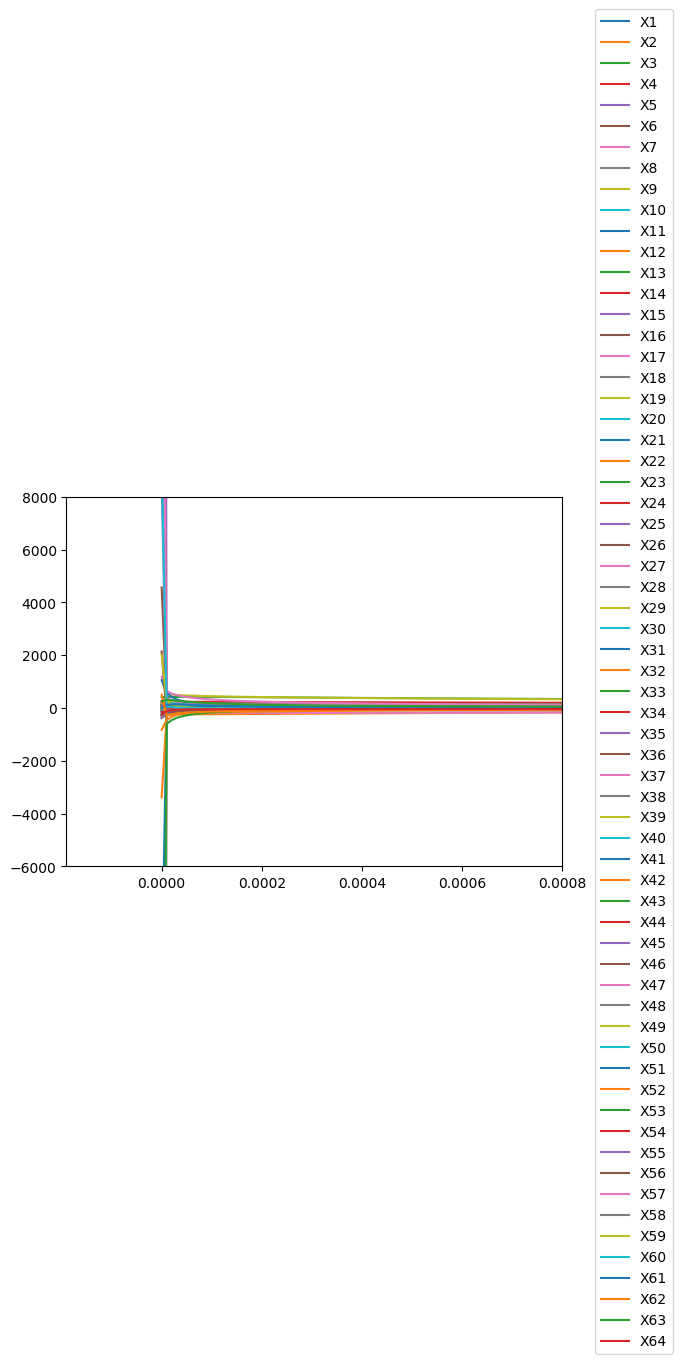

In [317]:
for i in range(p):
    plt.plot(alpha_vec, np.array(RR_coef)[:,i],label = "X%d"%(i+1))

plt.axis([-0.00019,0.0008,-6000,8000])    
plt.legend(loc="right",bbox_to_anchor=(1.25,0.5),borderaxespad=1)

# plt.savefig("./Fig_Ridge_trace.pdf",div=400)

岭迹图体现了一个特征的系数随 $\alpha$ 变化的趋势。
- 随着正则化参数 $\alpha$ 的增大，系数趋向于零，正则化效应越强。
- 如果 $\alpha$ 过大，可能会导致所有系数都接近零，模型变得过于简单。

因为该模型特征过多，很难从图中选择最优超参数，我们可以通过计算不同 $k(或 \alpha)$ 下的 $\text{VIF}$ 值，当 $\text{VIF}$ 符合临界值条件，且为最小的$k(或 \alpha)$，就是我们所选择的超参数。

##### **方差扩大因子法**
$$
C(k)=(\mathbf{X}'\mathbf{X}+k\mathbf{I})^{-1}\mathbf{X}'\mathbf{X}(\mathbf{X}'\mathbf{X}+k\mathbf{I})^{-1}
$$
定义矩阵 $C(k)$ 中对角线的元素 $c_{jj}(k)$ 为岭估计的方差扩大因子，其中 $c_{jj}(k)$ 随着 $k$ 的增大而减少。通过选择 $k$ 使得所有方差扩大因子 $c_{jj}(k)<c_{\text{VIF}}$，从而确定岭参数 $k$。

In [318]:
C_k = []
for alpha in alpha_vec:
    k = alpha * n_train
    c_k = np.linalg.inv(X_train_scaled.T @ X_train_scaled + k * np.eye(p)) @ X_train_scaled.T @ X_train_scaled @ np.linalg.inv(X_train_scaled.T @ X_train_scaled + k * np.eye(p))
    C_k.append(np.mean(np.diag(c_k)))

alpha_best = alpha_vec[np.min(np.where(np.array(C_k) < vif_cv))]
print("The chosen value of alpha is", alpha_best)

The chosen value of alpha is 4e-05


重新构建在最优的 $k(或 \alpha)$ 时的岭回归估计，如下：

In [ ]:
model_2 = sm.OLS(y_train_center,X_train_scaled).fit_regularized(L1_wt=0,alpha = alpha_best)
model_2_coef = model_2.params
# 岭回归的估计结果
model_2_coef

array([  41.57953954, -237.45874682,  425.74203737,  237.39089433,
        -75.07118589,  -69.18772596, -157.55863853,  201.49432404,
        486.57335232,   69.40097926,   77.41917581,   19.51838402,
        -66.79676573,   79.2559342 , -138.02219834,   -5.60490362,
        176.2658628 ,   79.20351986,  110.49730914,  127.61561012,
        -46.68763789,   -3.62952825, -113.27404389,  -40.64416901,
        125.2092041 ,   90.49153007,  141.76239835,   80.52319928,
         82.9785398 ,  100.88369246,  272.65661088, -211.36539818,
        -25.53806845,   -5.20260859, -127.87351526,  -18.60537965,
        146.41642337, -134.53613591,  131.96307648,  -72.00512225,
       -117.77229193,  -15.21384396,   42.18076426,  -58.75789481,
         49.43028329,   61.46076433,  -62.64724256,  106.90807182,
        -36.35272196,  143.1906519 ,    5.2034509 , -212.17739542,
       -314.64167754,  -50.70264196,  -52.95193463, -121.36037362,
        450.77053271,  -32.59367377,   51.9753317 ,   10.76366

#### **Model_3：主成分回归模型**

##### **基本思想**
$$
主成分回归=主成分分析+回归分析
$$
即用 $k$ 个自变量的线性变换（主成分）代替原本的 $p$ 个自变量 $(k<p)$

##### **估计方法**
- 假定设计矩阵 $\mathbf{X}$ 已标准化。假设 $\mathbf{X}'\mathbf{X}$ 的
    - 特征值为 $\lambda_1\ge\lambda_2\ge\cdots\ge\lambda_p$;
    - 其相应单位正交化后的特征向量为 $v_1,v_2,\cdots,v_p$.
- 令
    - $\Lambda = \text{diag}\{\lambda_1,\lambda_2,\cdots,\lambda_p\} $;
    - $ V'=(v_1,v_2,\cdots,v_p) $.
- 令 $\mathbf{Z}=\mathbf{XV}' $，那么
    $$
    \mathbf{Z}'\mathbf{Z}=\Lambda \\
    z_j = \mathbf{Xv}_j = (z_{1j},z_{2j},\cdots,z_{nj})'
    $$
- 第 $j$ 个主成分为
    $$
    z_j = v_{1j}\mathbf{x}_1 + v_{2j}\mathbf{x}_2 + \cdots + v_{pj}\mathbf{x}_p
    $$
- 记 $\mathbf{\alpha}=\mathbf{V}\mathbf{\beta}$
- 当 $|\mathbf{X}'\mathbf{X}|\approx0$ 时，存在一个 $k$，使得 $\lambda_{k+1},\cdots,\lambda_p$ 均近似为 0，因此，$z_{k+1},\cdots,z_p$ 近似为 0
- 将矩阵 $\mathbf{Z}$ 和向量 $\mathbf{\alpha}$ 按上述进行拆分
    $$
    \mathbf{\alpha} = (\mathbf{\alpha}_1',\mathbf{\alpha}_2')'\\
    \mathbf{Z} = (\mathbf{Z}_1,\mathbf{Z}_2)
    $$
- 因此线性回归模型可写为
    $$
    \mathbf{y} = \mathbf{Z}_1\mathbf{\alpha}_1 + \mathbf{Z}_2\mathbf{\alpha}_2 + \varepsilon = \mathbf{Z}_1\mathbf{\alpha}_1 + \varepsilon
    $$
- $\mathbf{\alpha}_1$ 的最小二乘估计为
    $$
    \hat{\mathbf{\alpha}_1}= (\mathbf{Z}_1'\mathbf{Z}_1)^{-1}\mathbf{Z}_1'\mathbf{y} = \mathbf{\Lambda}_1^{-1}\mathbf{Z}_1'\mathbf{y}
    $$
- 回归参数 $\mathbf{\beta}$ 的估计为
    $$
    \hat{\mathbf{\beta}_{\text{PC}}} = \mathbf{V}_1'\hat{\mathbf{\alpha}}_1=\mathbf{V}_1'\mathbf{\Lambda}_1^{-1}\mathbf{Z}_1'\mathbf{y}
    $$

首先进行主成分分析并输出每个主成分的贡献率：

In [321]:
model_pca = PCA(X_train_scaled,standardize = False, demean = True)
model_pca_cr = model_pca.eigenvals # contribution rate of each component
print("The percentages of total variance are", np.around(model_pca_cr,4))

The percentages of total variance are 0     10.5650
1      6.0232
2      5.1814
3      4.3221
4      3.1021
       ...   
59     0.0025
60     0.0019
61     0.0004
62     0.0000
63     0.0000
Name: eigenvals, Length: 64, dtype: float64


计算特征值并排序：

In [322]:
Corr_Mat = X_train_scaled.T @ X_train_scaled
Lambda, V = np.linalg.eig(Corr_Mat)
Lambda = sorted(Lambda,reverse = True)
print("The eigen values of X'X are ", np.around(Lambda,4))

The eigen values of X'X are  [1.0565e+01 6.0232e+00 5.1814e+00 4.3221e+00 3.1021e+00 2.9543e+00
 2.6052e+00 2.4767e+00 2.1426e+00 1.9491e+00 1.7006e+00 1.6295e+00
 1.4848e+00 1.1843e+00 1.1586e+00 1.0413e+00 9.9250e-01 9.6160e-01
 8.8580e-01 8.2390e-01 7.6160e-01 7.1640e-01 7.0840e-01 6.6350e-01
 6.5070e-01 6.1310e-01 5.7510e-01 5.2150e-01 5.0910e-01 4.9940e-01
 4.4580e-01 4.2330e-01 4.2080e-01 3.7790e-01 3.4910e-01 3.3320e-01
 2.8080e-01 2.7050e-01 2.6010e-01 2.2970e-01 2.2370e-01 2.1250e-01
 1.8280e-01 1.4550e-01 9.6100e-02 7.6300e-02 5.2900e-02 4.8200e-02
 4.0400e-02 3.1700e-02 2.3700e-02 2.1200e-02 1.5400e-02 9.6000e-03
 6.2000e-03 4.6000e-03 3.5000e-03 3.2000e-03 2.8000e-03 2.5000e-03
 1.9000e-03 4.0000e-04 0.0000e+00 0.0000e+00]


绘制 scree plot 来作出主成分个数的主观判断：

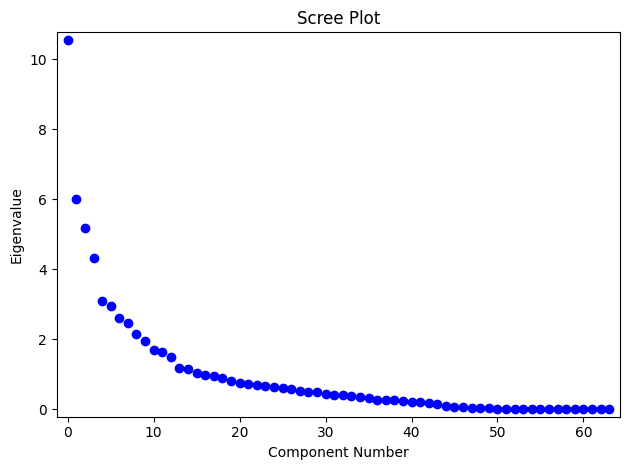

In [323]:
fig = model_pca.plot_scree(log_scale = False)

碎石图中最重要的部分是“拐点”/“肘部”。这通常是选择主成分数量的标准：
- 在肘部之前的主成分会显著解释数据中的方差（即，Y轴的数值较大）。
- 在肘部之后，主成分对总方差的贡献逐渐减小，贡献变得较小且趋于平稳（Y轴值接近零）。

除此之外，还可以计算每增加一个主成分后，对信息增量是多少？我们可以计算累积贡献率。

The cummulative percentages of total variance are 0     0.1651
1     0.2592
2     0.3402
3     0.4077
4     0.4562
       ...  
59    1.0000
60    1.0000
61    1.0000
62    1.0000
63    1.0000
Name: eigenvals, Length: 64, dtype: float64


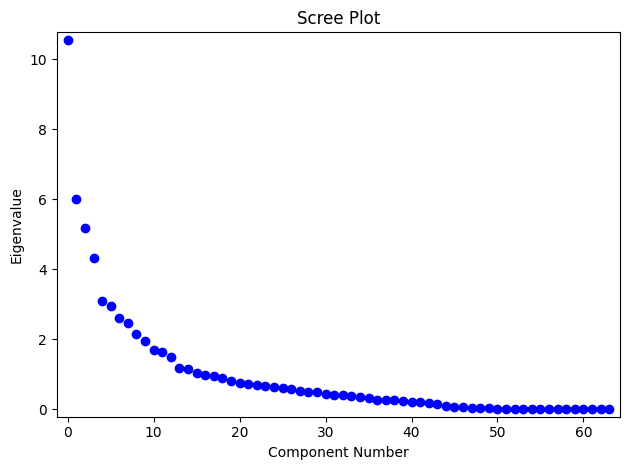

In [324]:
model_pca_ccr = np.cumsum(model_pca_cr)/p # cummulative contribution rate
print("The cummulative percentages of total variance are", np.around(model_pca_ccr,4))

fig = model_pca.plot_scree(log_scale = False)

我们选取主成分时需要其累积贡献率达到90%：

In [325]:
pca_cv = 0.90

根据阈值确定选取的主成分数量：

In [326]:
num_pca = np.min(np.where(model_pca_ccr > pca_cv))
print("The appropriate number of component is", (num_pca+1))

The appropriate number of component is 27


构建新特征（即主成分）代替原始特征，并拟合回归模型，接着通过线性变换估计主成分回归中的参数：

In [ ]:
model_pca_selected = PCA(X_train_scaled,  standardize = False,  demean = True)
V = model_pca_selected.loadings
Z_train_standardized= X_train_scaled @ V.iloc[:,0:(num_pca+1)]
model_3 = sm.OLS(y_train_center, Z_train_standardized).fit()
model_3_coef = V.T @ np.pad(model_3.params,(0,p-(num_pca+1)))

In [329]:
model_3_coef

comp_00    -85.424711
comp_01     67.617353
comp_02   -171.307225
comp_03    -69.611928
comp_04    -32.869311
              ...    
comp_59    105.574555
comp_60     17.829111
comp_61    -28.617638
comp_62     78.395314
comp_63     85.107270
Length: 64, dtype: float64

### **Step6.利用 RMSE 比较预测效果**

我们采用RMSE来作为衡量指标，即
$$
RMSE = \sqrt{n^{-1}\sum_{i=1}^n (\hat{y}_i - y_i)^2}
$$

#### **线性回归模型**
对于每一个数据$(\mathbf{x}_i,y_i)$，线性回归模型的预测结果为
$$
y_i^{\text{ols}} = \hat{\beta}_0 + \mathbf{x}_i \hat{\mathbf{\beta}}^{\text{ols}}
$$
这里
- $\hat{\beta}_0$采用训练集中响应变量的样本均值来估计；
- $\hat{\mathbf{\beta}}^{\text{ols}}$采用最小二乘估计；

In [331]:
y_train_mean = np.average(y_train)

y_pred_ols = y_train_mean + X_test_scaled @ model_1_coef
ols_rmse = np.sqrt(np.mean((y_pred_ols-y_test)**2))
print("The RMSE in the ordinary regression is", round(ols_rmse,4))

The RMSE in the ordinary regression is 612.0976


#### **岭回归模型**
对于每一个数据$(\mathbf{x}_i,y_i)$，岭回归模型的预测结果为
$$
y_i^{\text{rr}} = \hat{\beta}_0 + \mathbf{x}_i \hat{\mathbf{\beta}}^{\text{rr}}
$$
这里
- $\hat{\beta}_0$采用训练集中响应变量的样本均值来估计；
- $\hat{\mathbf{\beta}}^{\text{rr}}$采用岭回归估计；


In [332]:
y_pred_rr = y_train_mean + X_test_scaled @ model_2_coef
rr_rmse = np.sqrt(np.mean((y_pred_rr-y_test)**2))

print("The RMSE in the ridge regression is", round(rr_rmse,4))

The RMSE in the ridge regression is 79.8173


#### **主成分回归模型**
对于每一个数据$(\mathbf{x}_i,y_i)$，主成分回归模型的预测结果为
$$
y_i^{\text{pcr}} = \hat{\beta}_0 + \mathbf{x}_i \hat{\mathbf{\beta}}^{\text{pcr}}
$$
这里
- $\hat{\beta}_0$采用训练集中响应变量的样本均值来估计；
- $\hat{\mathbf{\beta}}^{\text{pcrr}}$采用主成分回归估计；

In [334]:
model_3_coef = model_3_coef.values.flatten()  # 转换为一维数组
y_pred_pcr = y_train_mean + X_test_scaled @ model_3_coef
pcr_rmse = np.sqrt(np.mean((y_pred_pcr-y_test)**2))

print("The RMSE in the principal component regression is", round(pcr_rmse,4))

The RMSE in the principal component regression is 102.3197


#### **比较与评论**

- **普通线性回归 (Model_1)**:
   - RMSE 值为 **612.0976**，这个值明显较高，说明普通线性回归在测试集上的预测误差较大。可能是由于多重共线性等问题，导致模型的拟合能力不足，产生了较大的预测误差。
   - 普通线性回归模型没有正则化，因此如果数据中存在较多的相关特征，容易导致过拟合或不稳定的结果。

- **岭回归 (Model_2)**:
   - RMSE 值为 **79.8173**，显著低于普通线性回归的 RMSE。岭回归通过引入 **L2 正则化**，有效地减少了过拟合，尤其是当数据存在多重共线性时，岭回归能够稳定回归系数，从而改善模型的预测能力。
   - 因此，岭回归的结果相较于普通线性回归更加稳健和准确。

- **主成分回归 (Model_3)**:
   - RMSE 值为 **102.3197**，虽然低于普通线性回归，但高于岭回归。主成分回归通过先进行 **主成分分析 (PCA)**，减少数据的维度，选择最能解释方差的主成分，进而减少特征之间的相关性。这种方法对高维数据（特征数较多）通常非常有效，尤其是在特征之间存在多重共线性的情况下。
   - 但是，PCA 可能会导致一些信息的丢失，因为它是基于方差选择特征，有时会丢掉一些对于预测非常重要的低方差特征。因此，虽然主成分回归的 RMSE 小于普通回归，但相对而言，它的表现逊色于岭回归。

综上所述，岭回归是最优选择，其次是主成分回归，表现最差的是普通线性回归模型。